In [1]:
import pandas as pd
import re
from konlpy.tag import Komoran
import json
import time
from collections import OrderedDict

In [6]:
GlowPick_reviews = pd.read_csv("GlowPick_뽀오얀 미소 발효 립&아이 리무버.csv", engine = "python", encoding = "utf-8-sig")

In [3]:
GlowPick_reviews.head()

,user_id,review_count,skin_type,age,rating,review
0,카리렝가,33,지성,24,4,무난하게 잘 지워져요 조금 많이 기름지긴 해요
1,세후닝,146,복합성,37,4,이가격에 이정도 세정력이면 \n저는 그냥 쓸거같아요 \n향은 거의없는편이고요 솜에...
2,전꿀꿀,13,건성,20,2,눈따갑고 먼가 찝찝한느낌
3,pmk619,25,복합성,33,3,화장솜에 묻혀 눈에 쫌 올려둔뒤 쓰윽 닦으면 잘 지워지긴해요\n근데 눈에 들어가면 ...
4,키리리니니ㅐ,45,복합성,30,5,리무버 기능 좋다고 추천있길래 1+1 기다렸다가 바로 샀는데 신기하게 저렴한데도 좋...


In [11]:
# JVM_PATH = "C:/Program Files/Java/jdk-10.0.2/bin/server/jvm.dll"

In [4]:
komoran = Komoran()

## 문장 분절 및 형태소 분석 함수

In [7]:
def split_sentences(text):
    all_sentences = []
    lines = [line for line in text.strip().splitlines() if line.strip()]
    for line in lines:
        sentences = re.split("(?<=[.?!])\s+", line.strip())
        all_sentences += sentences
    return all_sentences


In [8]:
def review_to_morph_anal(df, start, end) : 
    """
    input : array 형태의 review
    output :  큰 리스트 안에 작은 리스트 안에 형태소 분석 내용
    
    """
    
    result = []
    
    
    for idx, review in enumerate(df["review"][start : end]) : 
        splited_sentence = split_sentences(review)
        for splited in splited_sentence :
            if len(splited) == 0 :
                continue
            morph_sentence = komoran.pos(splited.strip())
            dic = {word: morph for word, morph in morph_sentence} 
        result.append(dic)    

    return result

In [5]:
len(GlowPick_reviews)

3258

In [10]:
test = GlowPick_reviews.head()

In [11]:
test["a"] = 1

/home/kang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
test.loc[ : , "a"][1] = 40

/home/kang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/kang/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


#### 형태소 분석과정에서 커널이 자꾸 죽는 현상 발생
- "the kernel appears to have died. It will restart automatically"
- 주피터 노트북으로 실행해서 그럴 수 있다는 이야기를 듣고 파이썬 파일로 만들어 ujson파일로 저장해보려 함
- 3주 정도 이 문제를 해결못하고 묶여둠. 결국 우분투에서 돌려서 해결

----

## 명사, 형용사, 어근 추출 후 wordcloud 그리는 함수

In [8]:
import sys
from collections import defaultdict
from collections import Counter
import ujson
import wordcloud
import matplotlib.pyplot as plt
import mmap
import math

from collections import Counter

In [9]:
def filter_morph_anal(morphemes) : 
    FEATURE_POSES = ["NNG", "NNP", "VV", "VA", "XR"]
    morph_anal = [(word, mor) for n in range(len(morphemes)) for word, mor in morphemes[n].items() if mor in FEATURE_POSES]
    return morph_anal

In [10]:
def get_word_counts_for_Noun(morph_anal) : 
    NOUNS = ["NNG", "NNP"]
    word_counts = [word[0] for word in morph_anal if word[1] in NOUNS]
    word_counts = {word : count for word, count in Counter(word_counts).items()}
    return word_counts

In [11]:
def get_word_counts_for_Adjective(morph_anal) : 
    ADJECTIVES = ["VV", "VA"]
    word_counts = [word[0] + "다" for word in morph_anal if word[1] in ADJECTIVES]
    word_counts = {word : count for word, count in Counter(word_counts).items()}
    return word_counts

In [12]:
def get_word_counts_for_Radix(morph_anal) : 
    RADIX = ["XR"]
    word_counts = [word[0] + "하다" for word in morph_anal if word[1] in RADIX]
    word_counts = {word : count for word, count in Counter(word_counts).items()}
    return word_counts

In [13]:
def build_cloud(word_counts, max_words) :
    ubuntu_font_path = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
    font_path = "C:/Windows/Fonts/gulim.ttc"
    cloud_gen = wordcloud.WordCloud(font_path = ubuntu_font_path, max_words = max_words, collocations = False, \
                                   max_font_size = 80)
    cloud = cloud_gen.generate_from_frequencies(word_counts)
    return cloud

In [14]:
def get_cloud(cloud) : 
    plt.figure(figsize = (10, 10))
    plt.axis("off")
    plt.imshow(cloud, interpolation = 'bilinear')

#### 아이리무버 wordcount- 글로우픽 

In [15]:
GlowPick_morph_sentece = review_to_morph_anal(GlowPick_reviews, 0, len(GlowPick_reviews))

In [17]:
GlowPick_morph_anal = filter_morph_anal(GlowPick_morph_sentece)

GlowPick_noun_count = get_word_counts_for_Noun(GlowPick_morph_anal)

GlowPick_adjective_count = get_word_counts_for_Adjective(GlowPick_morph_anal)

GlowPick_radix_count = get_word_counts_for_Radix(GlowPick_morph_anal)

#### 아이리무버 - 아리따움

In [4]:
Aritaum = pd.read_csv("Aritaum_뽀오얀 미소 발효 립 & 아이 리무버.csv")

In [5]:
Aritaum.head()

,user_id,channel,option,membership,rating,review
0,imy1220,MOBILE,대용량 250ml,스마트클럽,5,진짜 몇통째 사서 쓰고 있는지 모르겠어요 순하고 잘 지워지고 다른 거 사용하다가도 ...
1,coco7346,MOBILE,대용량 250ml,스마트클럽,5,행사하면 무조건 쟁이게 되는 템이에요!! 아이메이크업 지우다가 내용물이 눈 안으로 ...
2,smlove2465,MOBILE,일반용량 120ml,일반,5,항상 잘 쓰고있어요
3,necklace37,MOBILE,대용량 250ml,스마트클럽,5,매번 이것망 이용하고 있어요. 저는 좀 민감한 편이라 그런지 머르겠는데 다른 것들을...
4,woouk747,MOBILE,대용량 250ml,프라임,5,저자극이라서 쓰기 너무 좋아요!!눈에 들어가도 따갑지 않고 깨끗하게 잘 지워져서 몇...


In [33]:
Aritaum["channel"].unique()

array(['MOBILE', 'PC', 'APP'], dtype=object)

In [38]:
eval('Aritaum[Aritaum["rating"] < 4]')

,user_id,channel,option,membership,rating,review
30,mimic,MOBILE,일반용량 120ml,스마트클럽,3,눈이따갑지는 않습니다. 그러나 세척력이 조금 약한것같아요.
67,ddbsekdms,APP,대용량 250ml,스마트클럽,3,뽀오얀 미소 발효 립 &amp; 아이 리무버\r\r\n대용량 구매 했습니다.\r\r...
237,ohh950,MOBILE,대용량 250ml,스마트클럽,1,나랑은 안맞나봄... 눈이따갑고 열이남 이걸로 지우면 그뒤로 엄청 부움 왜그러는걸까...
250,soul9071,MOBILE,대용량 250ml,일반,1,매번 잘 사용하긴하는 제품인데\r\r\n오프라인 매장에서는 1&amp;#43;1제품...
360,sw10833,MOBILE,일반용량 120ml,스마트클럽,3,1&amp;#43;1행사를 해서 매우 저렴하게 구매했습니다.\r\r\n처음 사용해 ...
415,hellokitty12,MOBILE,대용량 250ml,일반,2,배송 빠르고 좋아요\r\r\n다만 샘플 뚜껑이 살짝 열려있어서 좀 아쉽네요\r\r\...
423,hbkim100,MOBILE,일반용량 120ml,일반,2,립앤아이 리무버는 이것만 쓰고있어요~\r\r\n자극적이지도 않고 알콜 향도 안나도 ...
439,surolady,MOBILE,일반용량 120ml,일반,3,사이즈가 더 작아졌네요
490,wndud0259,MOBILE,대용량 250ml,프라임,3,눈에 자극적이지 않을 정도로 순해서 눈 화장이 잘 안 지워지면 어쩌나 했는데 걱정 ...
622,rkgusch123,MOBILE,대용량 250ml,스마트클럽,3,세정력은 진짜좋아요. 평소 스모키 화장만하는데\r\r\n워터프루프까지 싹잘지워집니다.


In [20]:
len(Aritaum)

3074

In [21]:
Aritaum_morph = review_to_morph_anal(Aritaum, 0, len(Aritaum))

#### 아이리무버 wordcount - 아리따움

In [22]:
Aritaum_filtered_morph_anal = filter_morph_anal(Aritaum_morph)

Aritaum_noun_count = get_word_counts_for_Noun(Aritaum_filtered_morph_anal)

Aritaum_adjective_count = get_word_counts_for_Adjective(Aritaum_filtered_morph_anal)

Aritaum_radix_count = get_word_counts_for_Radix(Aritaum_filtered_morph_anal)

#### 명사 - 아리따움

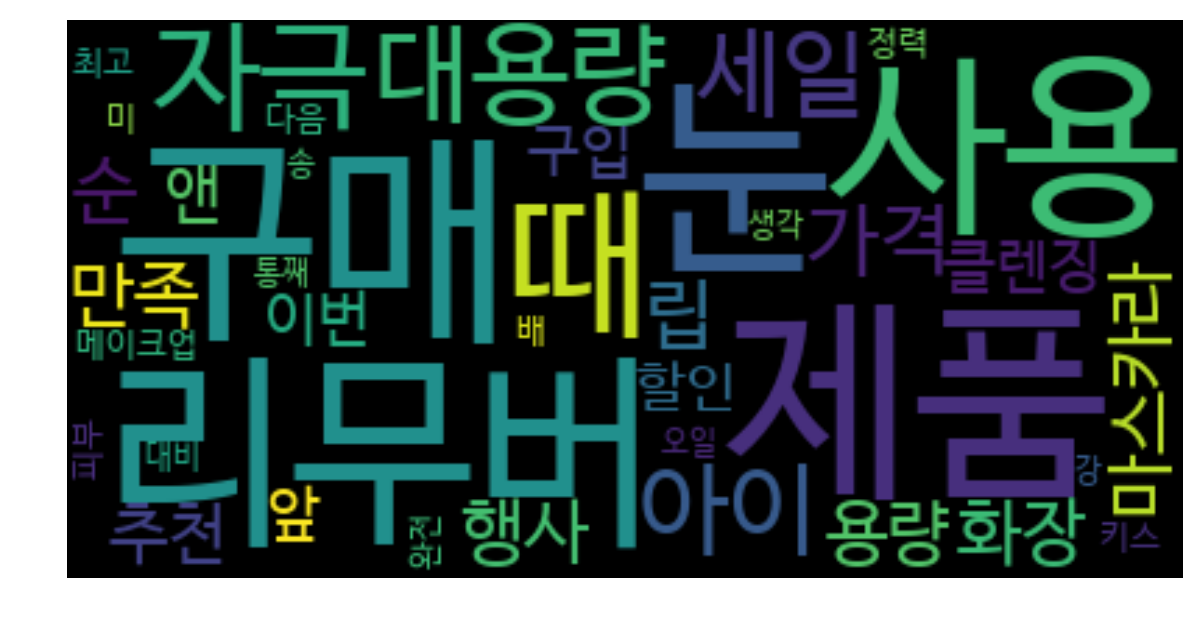

In [24]:
Aritaum_noun = build_cloud(Aritaum_noun_count, 40)
get_cloud(Aritaum_noun)

#### 명사 - 글로우픽

In [33]:
GlowPick_noun_count

{'욕': 3,
 '정력': 209,
 '친구': 24,
 '세일': 206,
 '때': 423,
 '사면': 66,
 '눈': 836,
 '제품': 312,
 '라인': 4,
 '구매': 154,
 '개인': 20,
 '주변': 11,
 '스킨푸드': 43,
 '오일': 81,
 '사용': 130,
 '자극': 201,
 '용량': 54,
 '가격': 196,
 '바닐라코': 2,
 '아이': 153,
 '리무버': 342,
 '처음': 29,
 '의사': 66,
 '적극': 2,
 '추천': 63,
 '나쁘지 않아': 2,
 '인생': 6,
 '사랑해요': 2,
 '제일': 44,
 '옛날': 2,
 '요즘': 13,
 '냄새': 45,
 '조금': 11,
 '키스': 143,
 '미': 156,
 '마스카라': 195,
 '한번': 36,
 '중상': 1,
 '눈물': 5,
 '행사': 35,
 '그때': 11,
 '화장': 150,
 '솜': 70,
 '부위': 2,
 '정도': 74,
 '단점': 27,
 '필요': 24,
 '동안': 8,
 '최고': 25,
 '이번': 13,
 '쌍': 8,
 '액': 9,
 '아이라인': 22,
 '입술': 28,
 '쉐도우': 1,
 '부족함': 1,
 '만족감': 1,
 '시림': 16,
 '생각': 63,
 '페리페라': 5,
 '틴트': 18,
 '립': 121,
 '착색': 12,
 '마음': 17,
 '앤': 62,
 '기대': 13,
 '절약': 1,
 '클렌징': 56,
 '통째': 47,
 '세안': 13,
 '조어': 1,
 '발효': 10,
 '건강': 2,
 '완': 2,
 '죤': 1,
 '굿': 45,
 '대신': 7,
 '눈가': 22,
 '피부': 39,
 '장': 1,
 '땡': 3,
 '암': 8,
 '입': 13,
 '고생': 2,
 '기억': 7,
 '건지': 9,
 '향도': 53,
 '기름': 30,
 '안': 93,
 '할거': 8,
 '기름기': 13,
 '폼': 8,


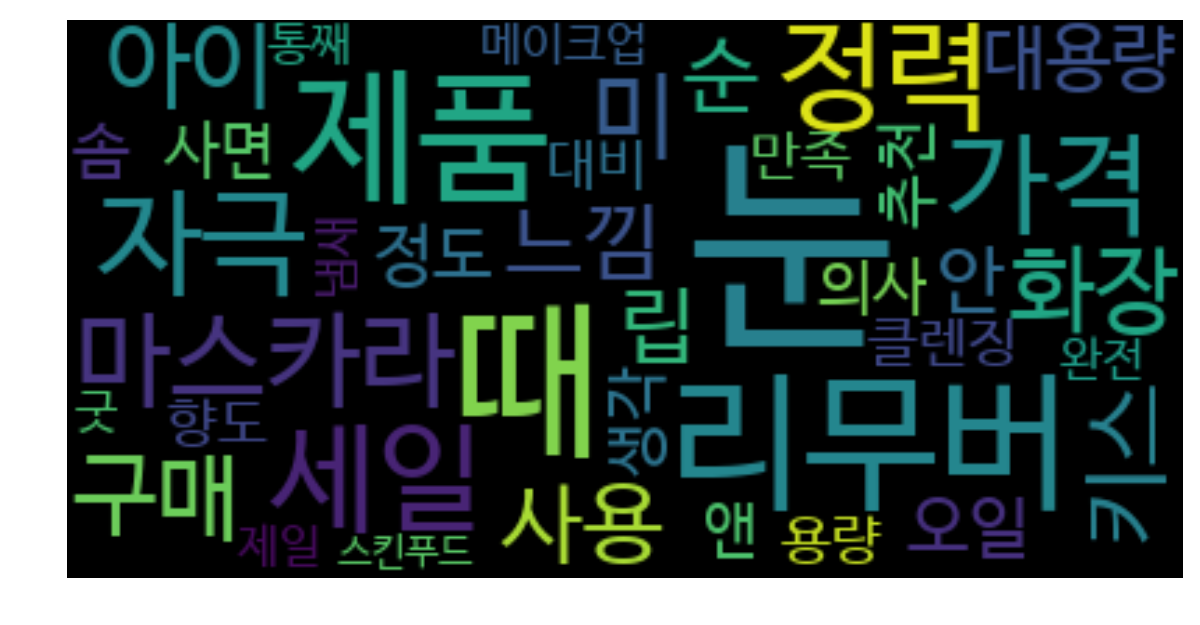

In [25]:
GlowPick_noun = build_cloud(GlowPick_noun_count, 40)
get_cloud(GlowPick_noun)

#### 형용사 - 아리따움

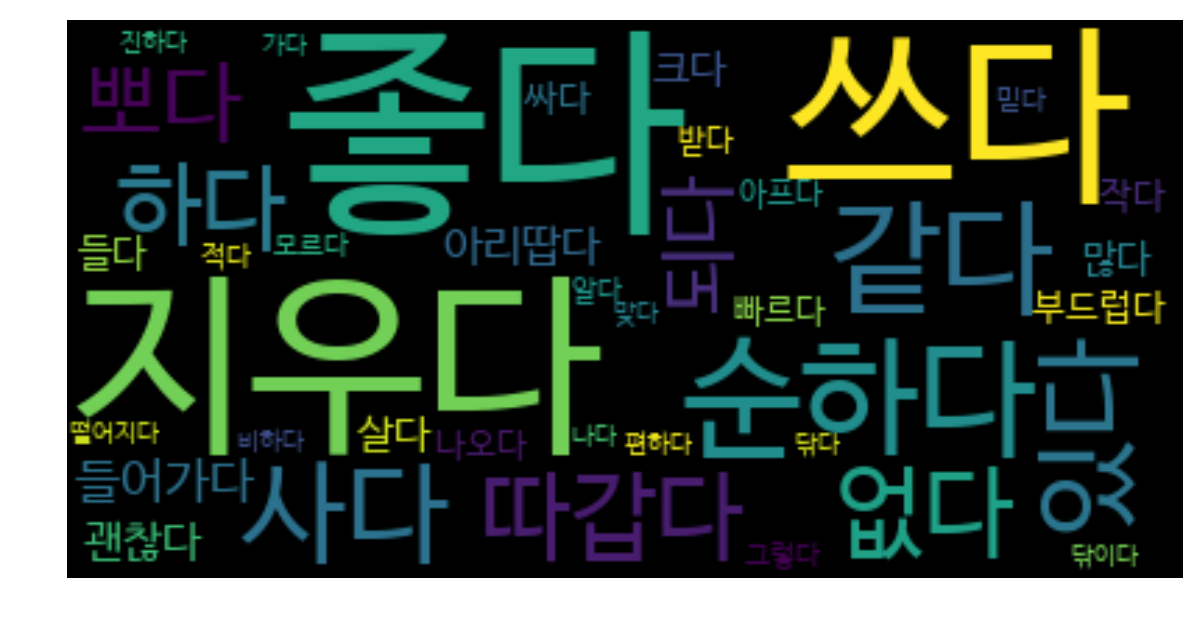

In [26]:
Aritaum_adjective = build_cloud(Aritaum_adjective_count, 40)
get_cloud(Aritaum_adjective)

#### 형용사 - 글로우픽

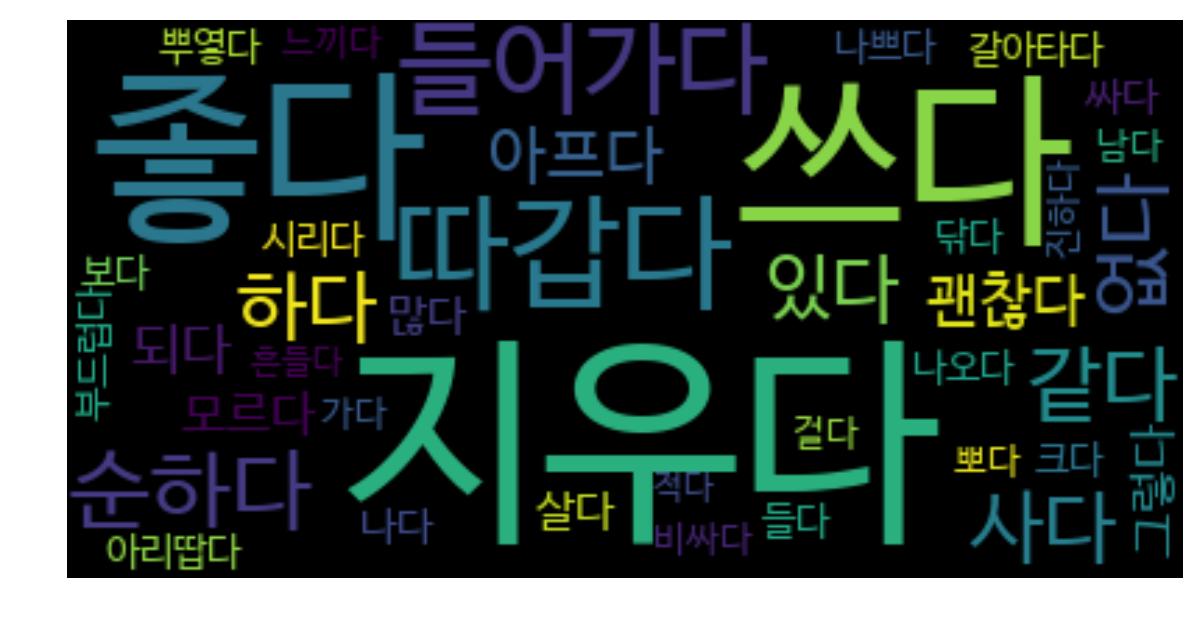

In [27]:
GlowPick_adjective = build_cloud(GlowPick_adjective_count, 40)
get_cloud(GlowPick_adjective)

#### 어근 - 아리따움

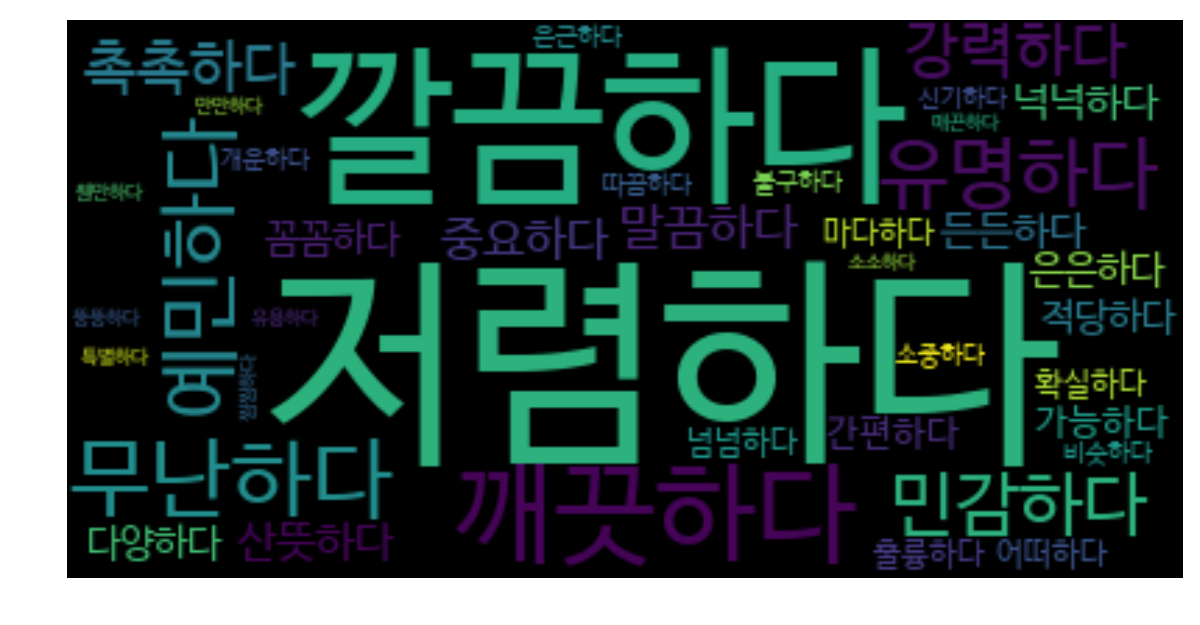

In [28]:
Aritaum_radix = build_cloud(Aritaum_radix_count, 40)
get_cloud(Aritaum_radix)

#### 어근 - 글로우픽

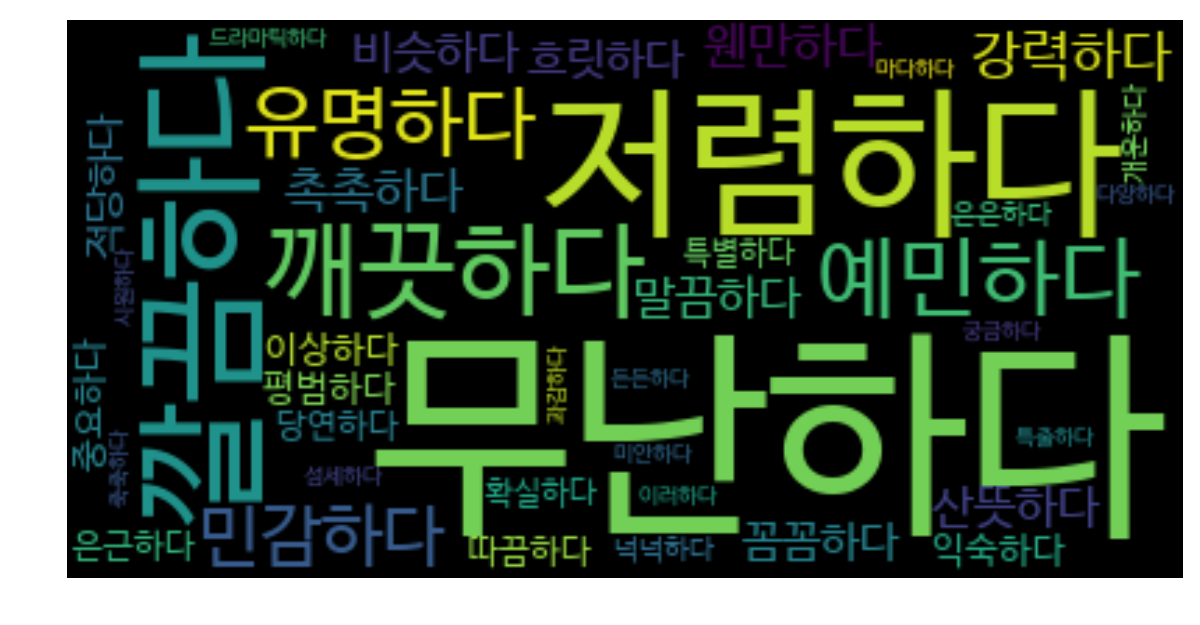

In [29]:
GlowPick_radix = build_cloud(GlowPick_radix_count, 40)
get_cloud(GlowPick_radix)